# Kona Coffee IBM Unsupervised

This anaylisis will continue exploring the Kona Coffee dataset that I am preparing for a volunteer project to identify yields of coffee plants. We will explore how the berry masks that have been identified can be clustered together utilizing unsupervised learning techniques.

## Dataset

The dataset consists of images taken from a coffee farm using a DSLR camera standing at a fixed distance. The masks in the dataset were manually annotated but automatically cropped utilizing the Segment Anything model. To obtain the image that will be used for testing classification, we apply the mask to the image and then crop the result down to the bounding box of the mask. From there, we then get the average color of the center pixels (utilizing a fixed radius) to obtain the features to classify: red, green, and blue.

## Objective

Utilizing domain knowledge of how coffee berries are expected to appear in their lifecycles, attempt to produce an unsupervised clustering of the berries that can be used to identify which class of lifecycle the berry is in. Without the actual class labels, we need to rely on visual inspection to determine if the clustering is accurate.

In [124]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")

df = pd.read_csv('../../../kona_coffee/pipeline/validated.csv')

df = df[df.valid == True]

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 518 entries, 0 to 775
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   518 non-null    object
 1   x       518 non-null    int64 
 2   y       518 non-null    int64 
 3   mask    518 non-null    object
 4   valid   518 non-null    bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 20.7+ KB


In [123]:
df.describe()

x           y
count  518.000000  518.000000
mean   213.507722  201.187259
std    104.023538   99.330650
min     10.000000    9.000000
25%    133.250000  124.250000
50%    214.000000  198.500000
75%    304.750000  284.000000
max    391.000000  386.000000

In [117]:
def get_display_image(row):
    """
    Get the display image for the mask. Crops the image to the mask.
    """
    cv2image = cv2.imread(row.image)
    cv2image = cv2.cvtColor(cv2image, cv2.COLOR_BGR2RGB)

    mask = np.load(row.mask)
    mask = mask.astype(np.uint8)
    
    # apply the mask to the image
    mask_image = cv2.bitwise_and(cv2image, cv2image, mask=mask)
    
    # crop the image to the mask
    mask_image = mask_image[np.ix_(mask.any(1),mask.any(0))]
    
    return mask_image


def get_image_features(image):
    """
    Manually extract features from the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    width, height, channels = image.shape
    
    cx, cy = width/2, height/2
    radius = 10
    
    # get the center pixel circle with radius 10
    center_pixel = image[int(cx-radius):int(cx+radius), int(cy-radius):int(cy+radius), :]
    
    # get the mean and std of the center pixel
    center_pixel_mean = np.mean(center_pixel, axis=(0,1))
    
    red_c = center_pixel_mean[0]
    green_c = center_pixel_mean[1]
    blue_c = center_pixel_mean[2]
    
    return [red_c, green_c, blue_c]

In [125]:
from tqdm import tqdm

fdf = []

for row in tqdm(df.itertuples(), total=len(df)):
    image = get_display_image(row)
    features = get_image_features(image)
    fdf.append([row.image, row.mask, features])

fdf = pd.DataFrame(fdf, columns=['image', 'mask', 'features'])

fdf['red_c'] = fdf.features.apply(lambda x: x[0]/255)
fdf['green_c'] = fdf.features.apply(lambda x: x[1]/255)
fdf['blue_c'] = fdf.features.apply(lambda x: x[2]/255)

fdf

100%|██████████| 518/518 [00:02<00:00, 223.49it/s]


image  \
0    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
1    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
2    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
3    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
4    /home/jack/Mounts/DiskOne/kona_coffee/splits/1...   
..                                                 ...   
513  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
514  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
515  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
516  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   
517  /home/jack/Mounts/DiskOne/kona_coffee/augmente...   

                                                  mask  \
0    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
1    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
2    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
3    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
4    /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
..                                                 ...   
513  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
514  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
515  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
516  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   
517  /home/jack/Mounts/DiskOne/kona_coffee/masks/10...   

                          features     red_c   green_c    blue_c  
0      [17.0575, 46.5875, 80.8525]  0.066892  0.182696  0.317069  
1       [17.485, 19.5525, 19.1525]  0.068569  0.076676  0.075108  
2      [20.7025, 25.7825, 24.7675]  0.081186  0.101108  0.097127  
3      [30.7225, 25.9275, 24.8725]  0.120480  0.101676  0.097539  
4     [29.2025, 20.9425, 134.2175]  0.114520  0.082127  0.526343  
..                             ...       ...       ...       ...  
513     [129.7525, 201.83, 242.18]  0.508833  0.791490  0.949725  
514  [101.4925, 86.1425, 170.7775]  0.398010  0.337814  0.669716  
515   [73.7825, 84.2925, 111.9825]  0.289343  0.330559  0.439147  
516     [72.935, 61.0575, 161.775]  0.286020  0.239441  0.634412  
517     [8.0675, 19.5675, 15.9525]  0.031637  0.076735  0.062559  

[518 rows x 6 columns]

In [126]:
from sklearn.cluster import KMeans

def kmeans_inertia(scaled_data, k, alpha_k=0.02):
    inertia_o = np.square((scaled_data - scaled_data.mean(axis=0))).sum()
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scaled_data)
    scaled_inertia = kmeans.inertia_ / inertia_o + alpha_k * k
    return scaled_inertia

def best_kmeans(scaled_data, k_range):
    ans = []
    for k in k_range:
        scaled_inertia = kmeans_inertia(scaled_data, k)
        ans.append((k, scaled_inertia))
    results = pd.DataFrame(ans, columns = ['k','Scaled Inertia']).set_index('k')
    best_k = results.idxmin()[0]
    return best_k, results


def plot_sample_images_from_groups(data):
    for group in data.groupby('labels'):
        dfg = group[1]
        
        # display distribution of red, green, blue
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        axes = axes.flatten()
        for i, color in enumerate(['red_c', 'green_c', 'blue_c']):
            sns.histplot(
                dfg[color],
                ax=axes[i],
                kde=True,
                color=color[:-2]
            )
        
        # sample 10 images from the group
        sample = dfg.sample(10, replace=True)
        
        # plot the images
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))

        # no axis
        for ax in axes.flatten():
            ax.axis('off')
        
        axes = axes.flatten()
        for i, row in enumerate(sample.itertuples()):
            image = get_display_image(row)
            axes[i].imshow(image)
            
        # set title to the group label
        fig.suptitle(f'Group: {group[0]}, total: {len(dfg)}')
        plt.show()

To begin our tests to see if we can classify the berries to their lifecycle, we will start with the popular KMeans. Utilizing the above methods, we will detect the best k utilizing the "elbow" method.

In [127]:
x = fdf[['red_c', 'green_c', 'blue_c']].to_numpy()

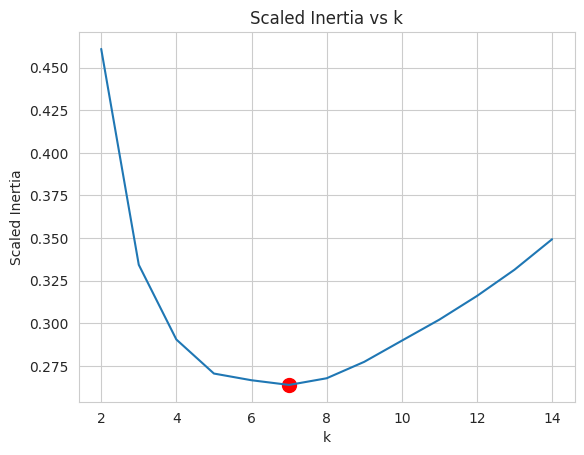

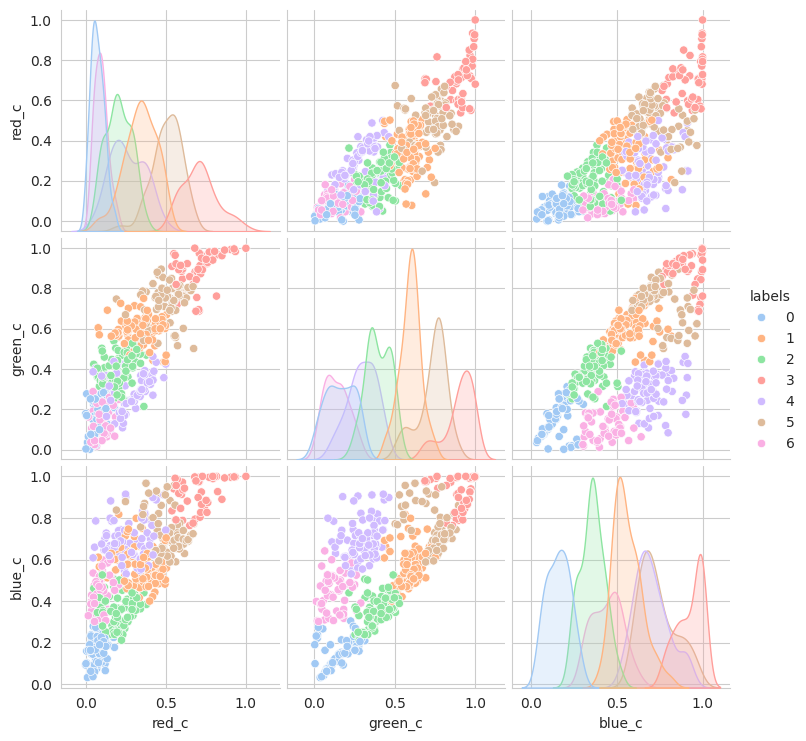

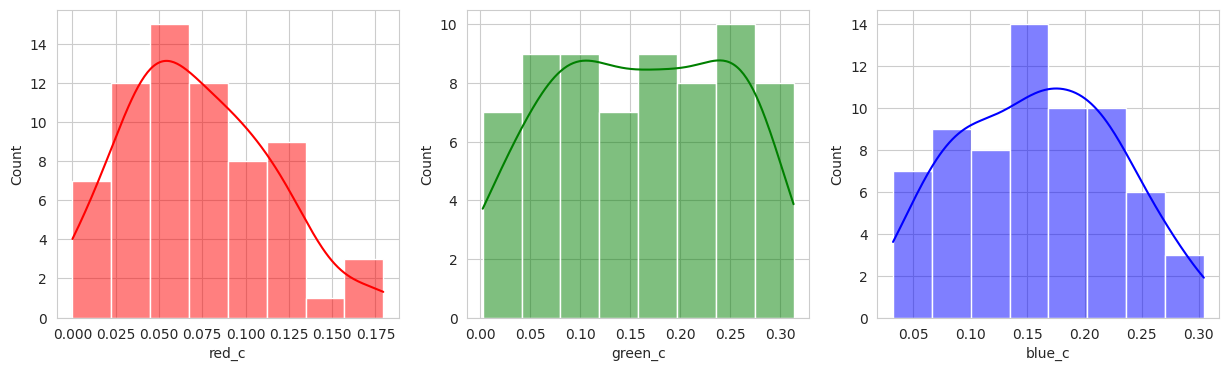

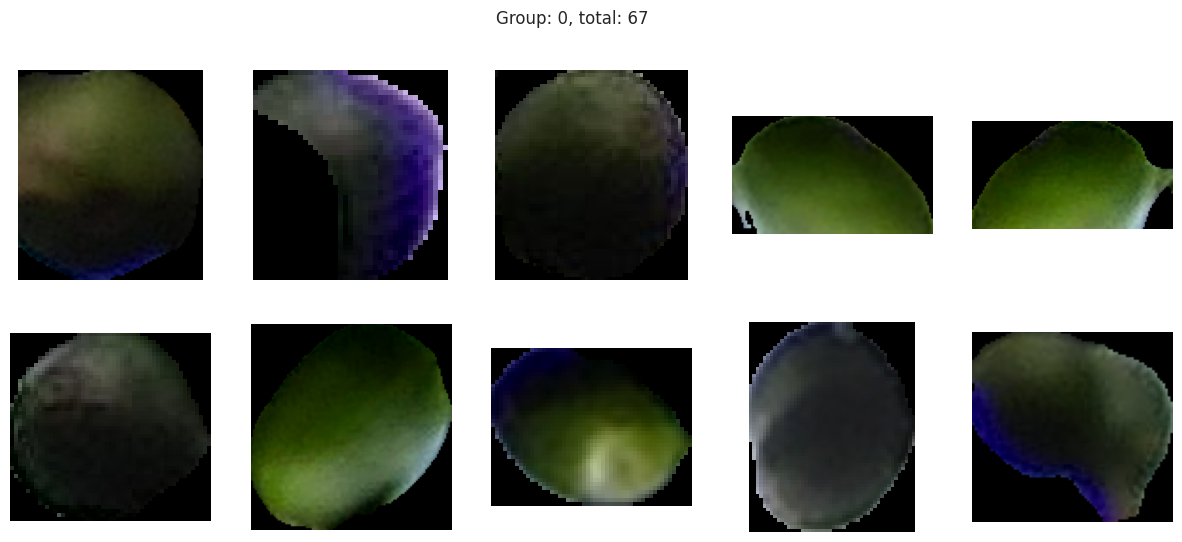

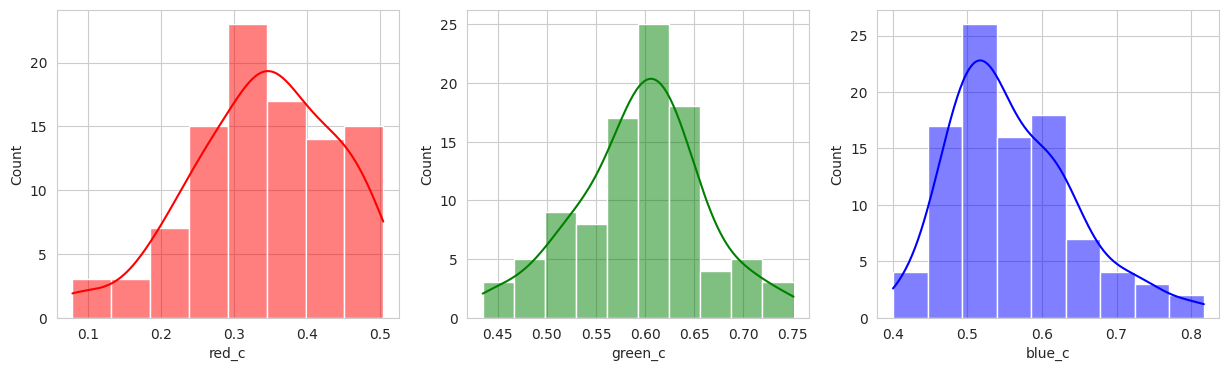

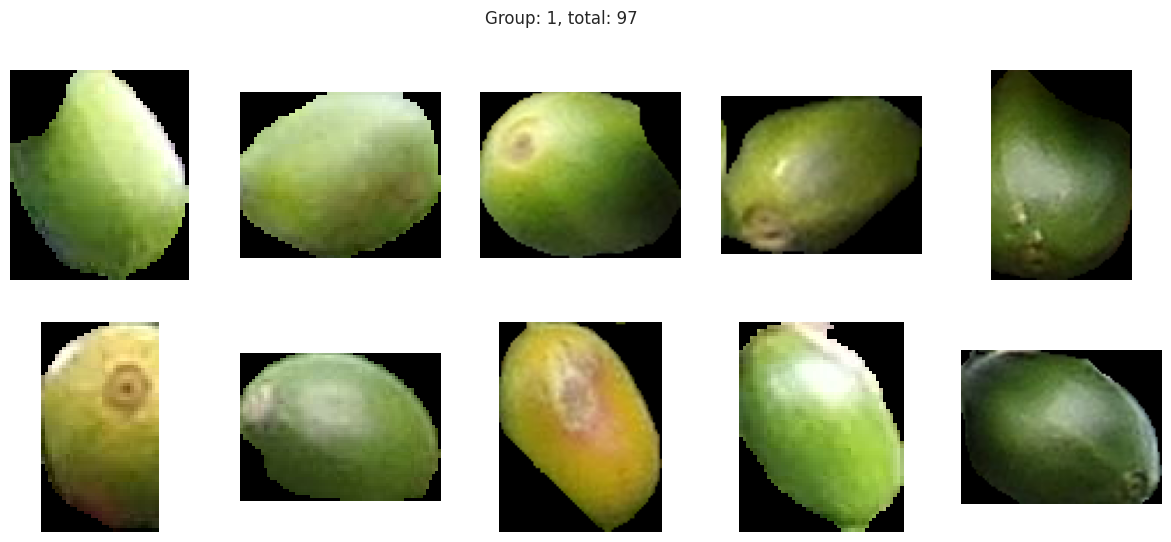

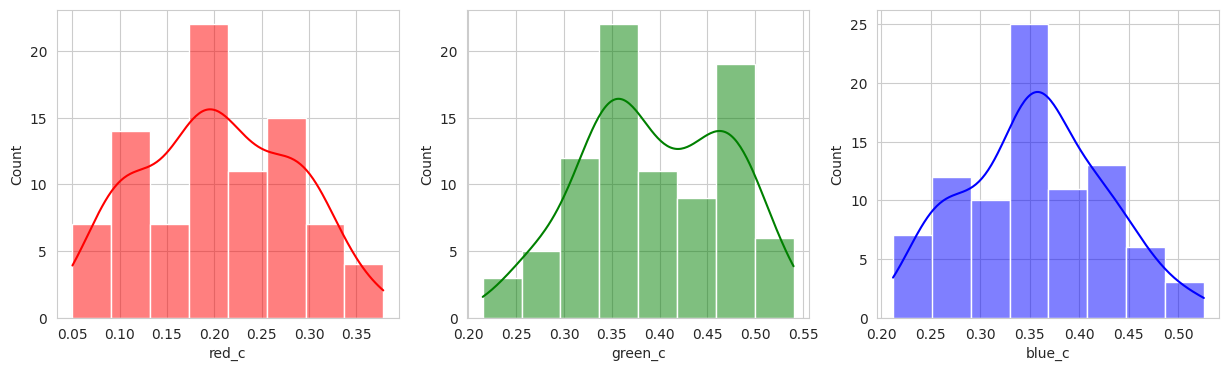

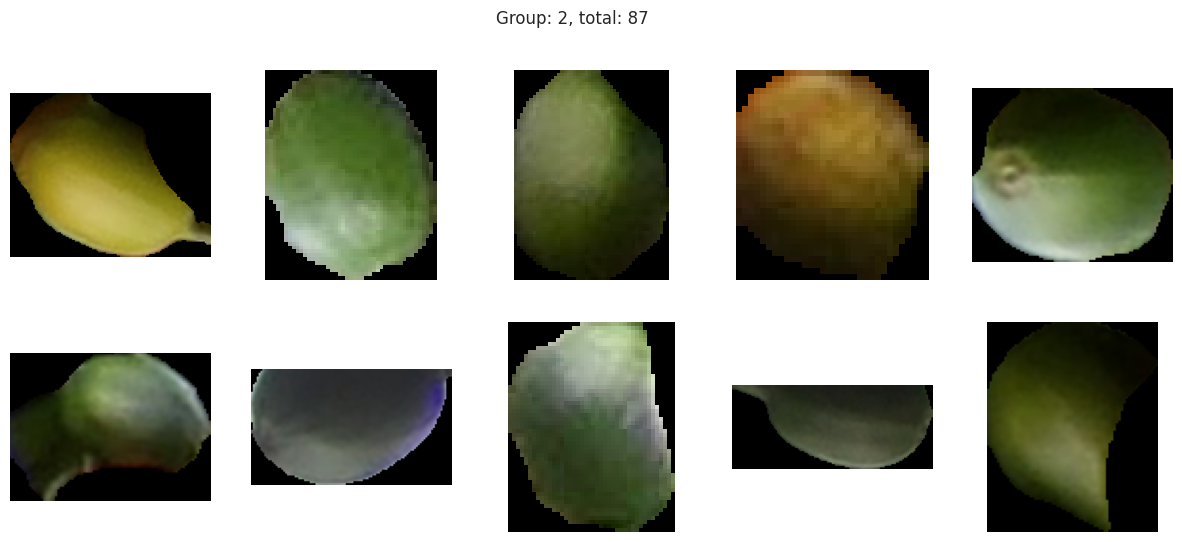

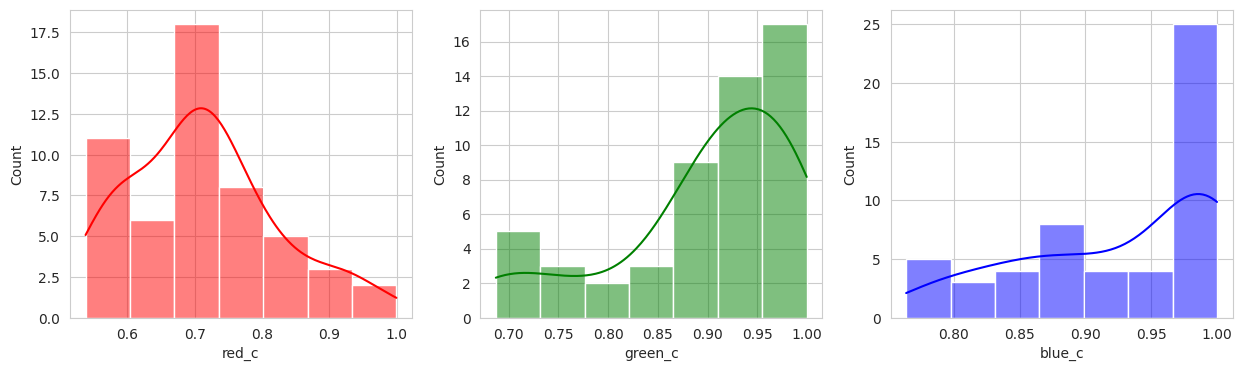

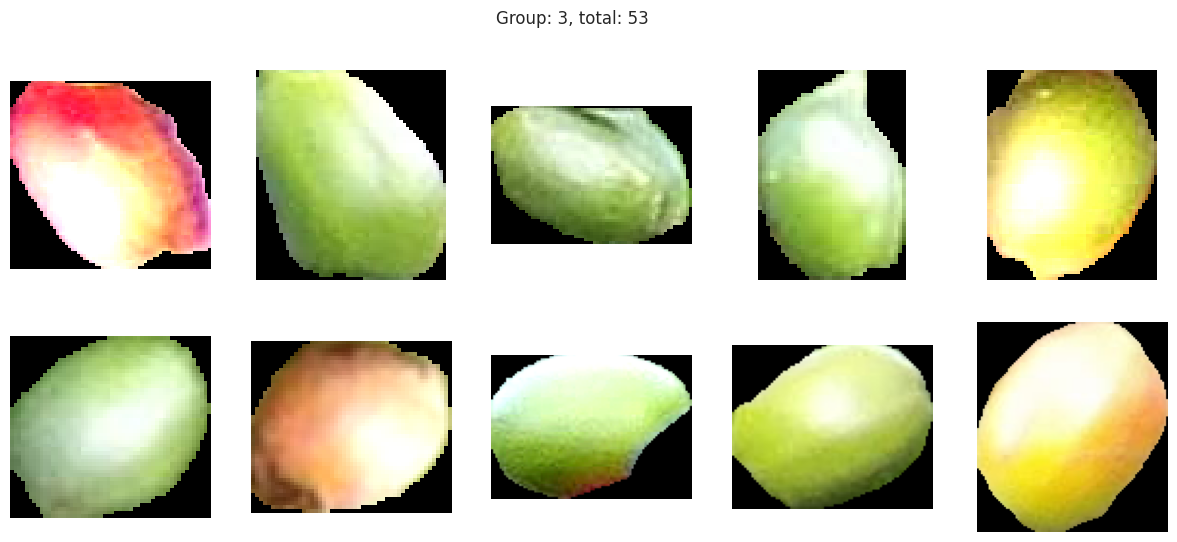

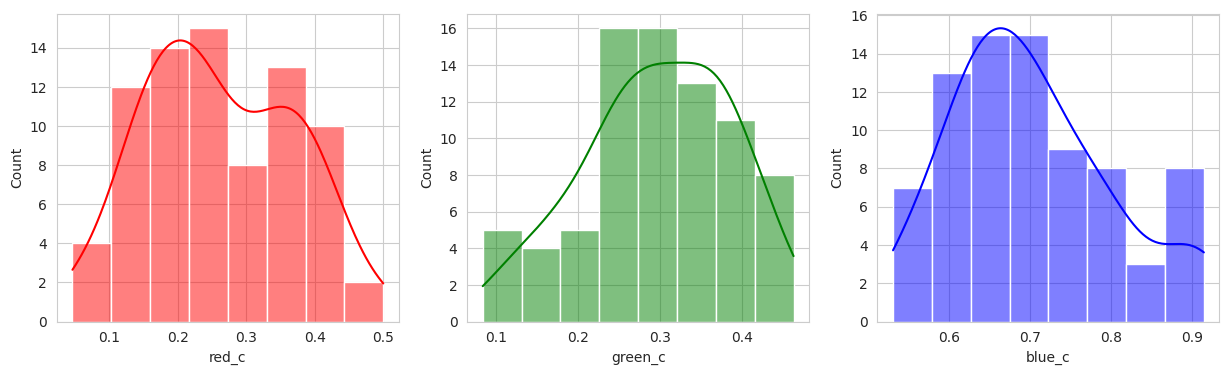

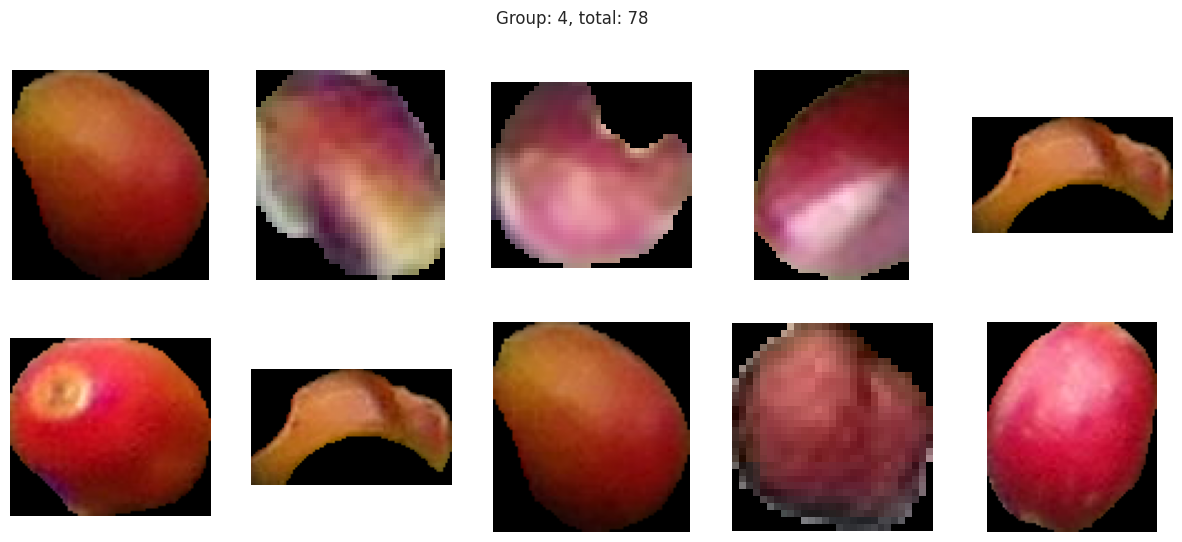

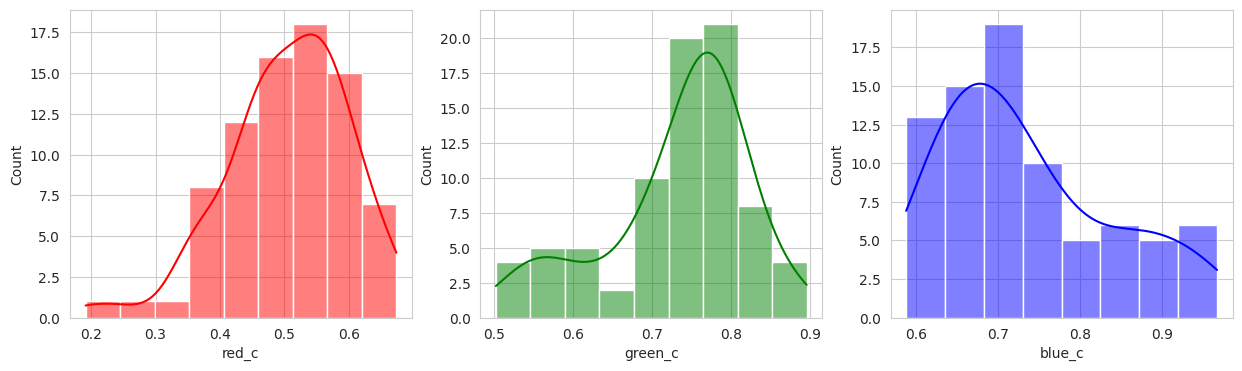

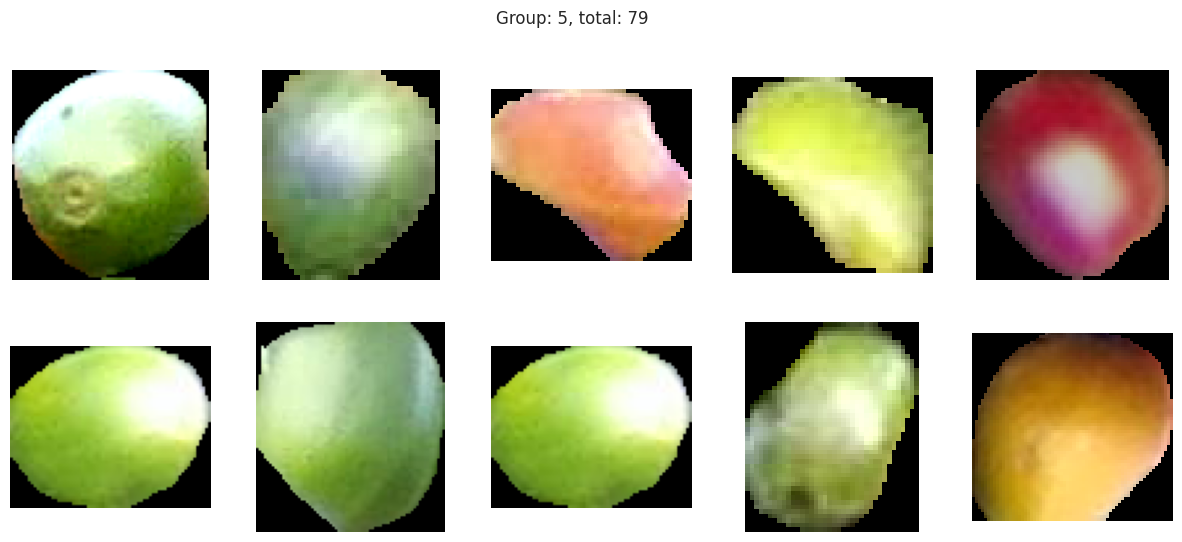

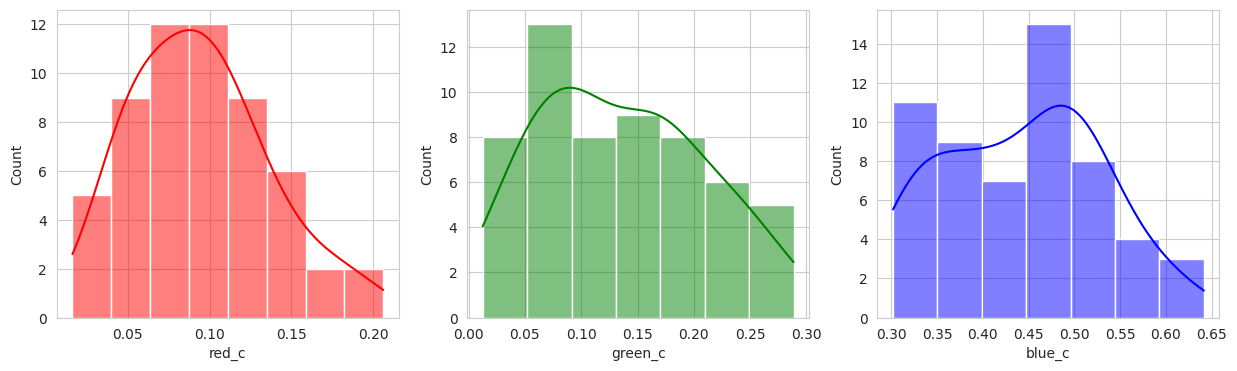

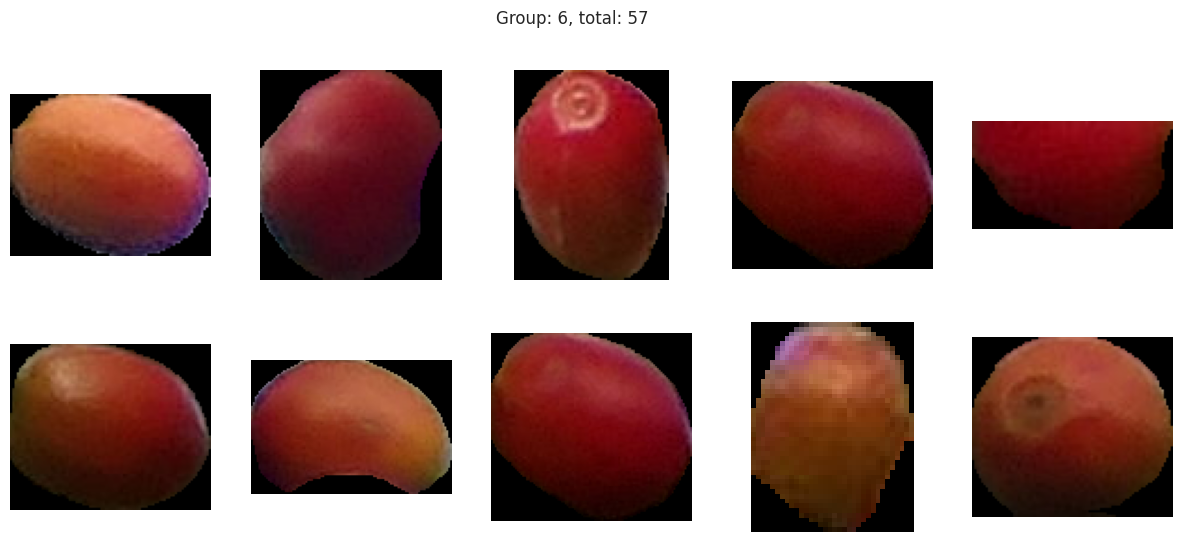

In [128]:
from sklearn.cluster import KMeans

best_k, results = best_kmeans(x, range(2, 15))
model = KMeans(n_clusters=best_k, random_state=0)

plt.xlabel('k')
plt.ylabel('Scaled Inertia')
plt.title('Scaled Inertia vs k')
plt.plot(results)
plt.scatter(best_k, results.loc[best_k], c='r', s=100)
plt.show()

model.fit(x)

labels = model.predict(x)
fdf['labels'] = labels

sns.pairplot(
    fdf,
    hue='labels',
    palette='pastel',
)

plot_sample_images_from_groups(fdf)

The initial results are very very promising. It appears that the berries have been categorized into different clusters based on their lifecycle within the first run of the model.

Group 0 and 1 appear to contain green berries, where 0 appears darker and 1 is lighter. Visually, this appears to be due to constrasting lighting conditions and not the actual hue of the berry.

Group 2, 3, and 5 are a bit of a mystery. But, they appear to contain berries that may be of "ripening" quality. Group 3 contains a lot of blue and green in the distribution, but also a high amount of red.

Group 4 and 6 we can see contain what might be considered "ripe" berries as all of the berries are red in hue.

Given this, we could easily stop and apply labels to group 0 and 1 with "unripe", group 2, 3, and 5 with "ripening", and group 4 and 6 with "ripe". But, we should explore other models to see if we can get a better clustering.

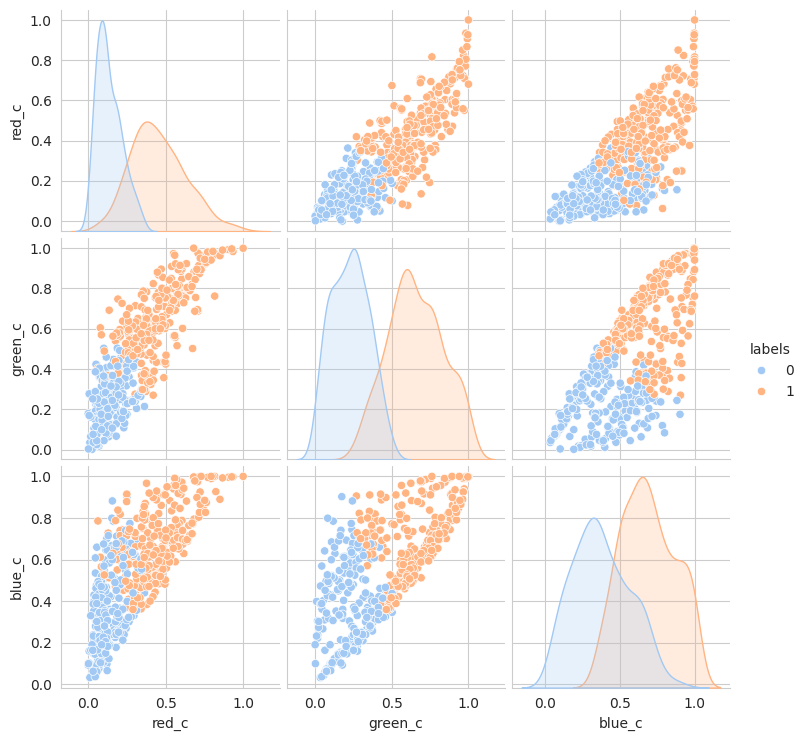

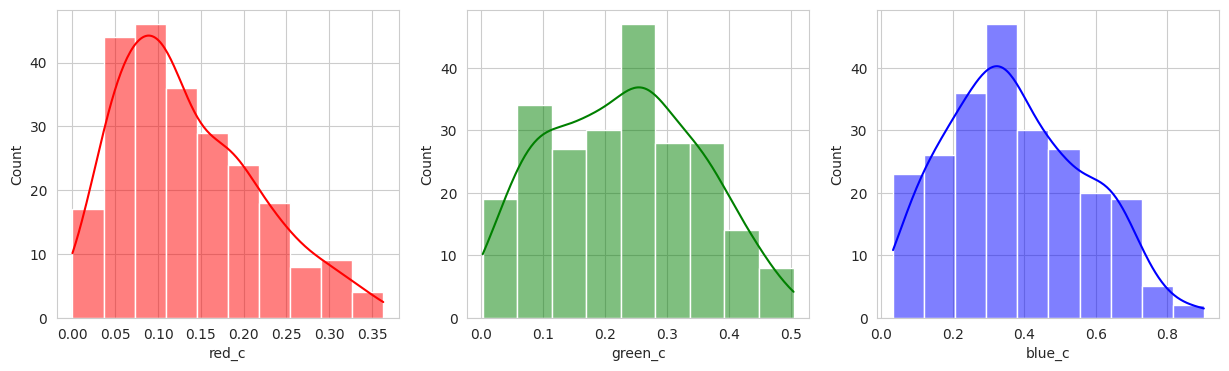

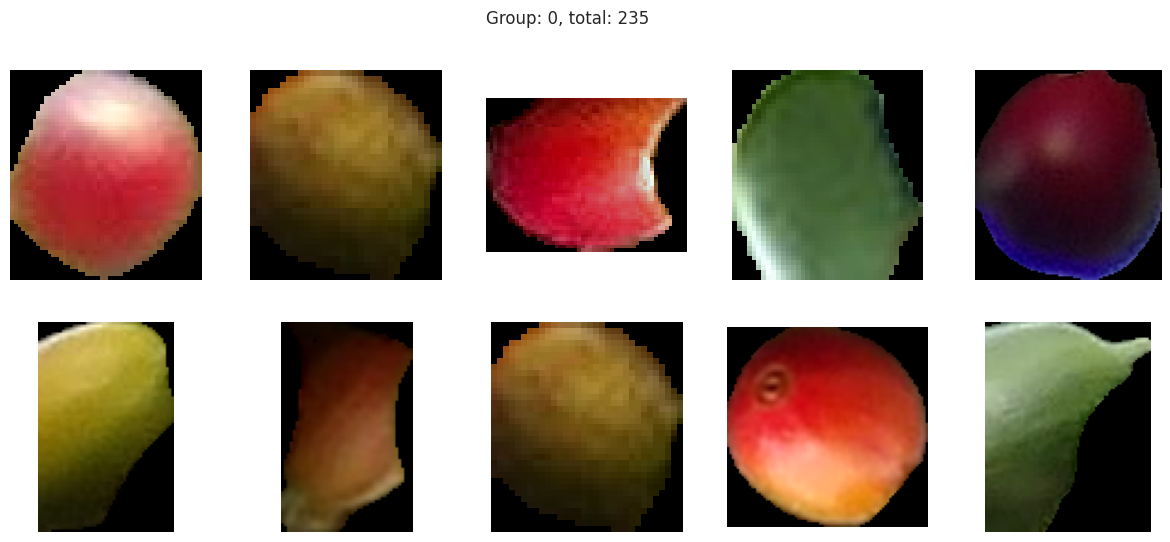

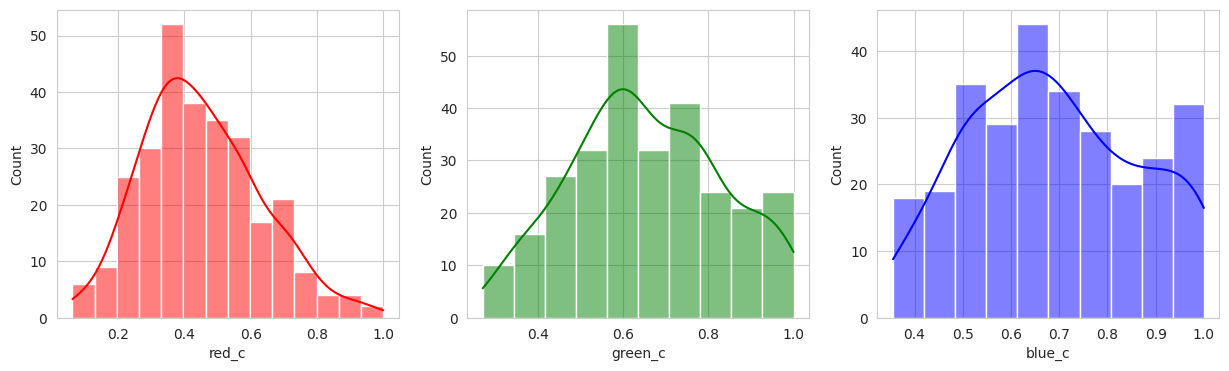

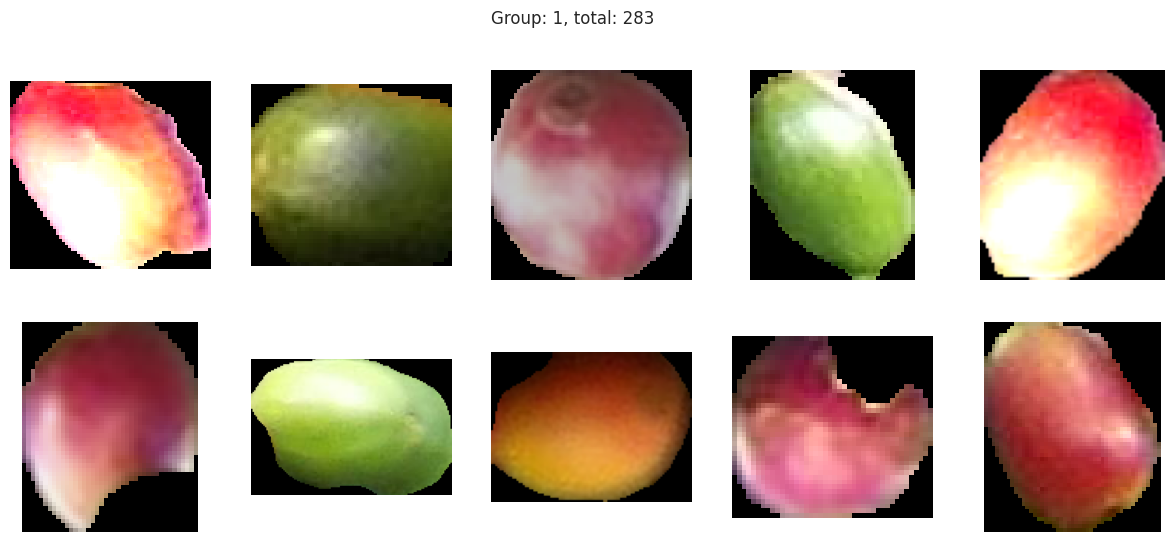

In [134]:
from sklearn.cluster import MeanShift, estimate_bandwidth

bandwidth = estimate_bandwidth(x, quantile=0.2, random_state=0, n_jobs=-1)
model = MeanShift(bin_seeding=True, bandwidth=bandwidth)

model.fit(x)

labels = model.predict(x)
fdf['labels'] = labels

sns.pairplot(
    fdf,
    hue='labels',
    palette='pastel',
)

plot_sample_images_from_groups(fdf)

I played with the hyperparameters quite a bit, but visually, I couldn't get a better clustering than the KMeans. With two seperate groups identified, we can conclude with our domain knowledge that this model is performing poorly.

But perhaps the DBSCAN model can do better. Considering it also deals with strange shapes, it may be able to identify the berries better.

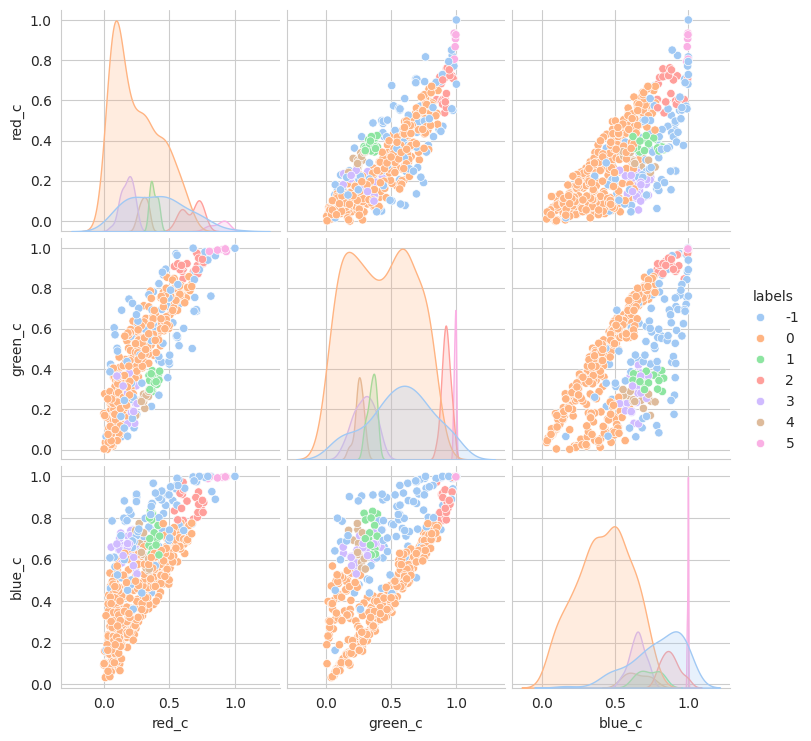

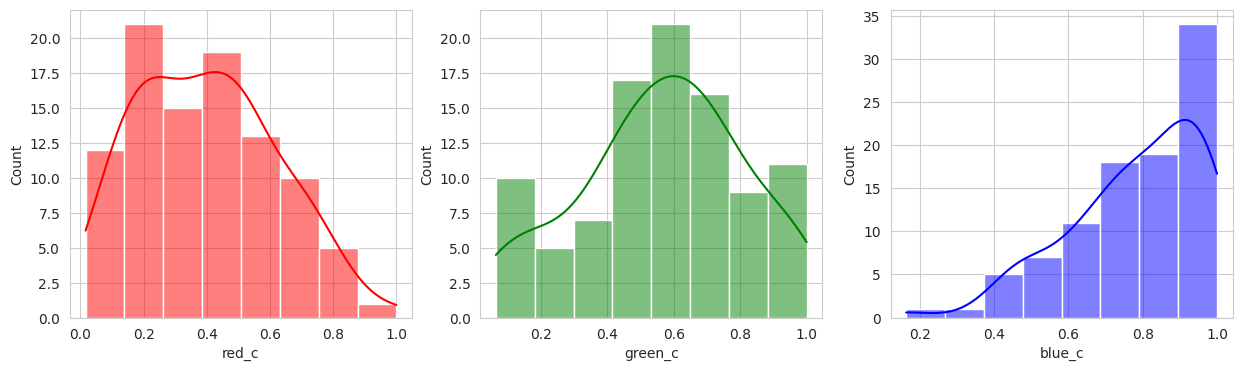

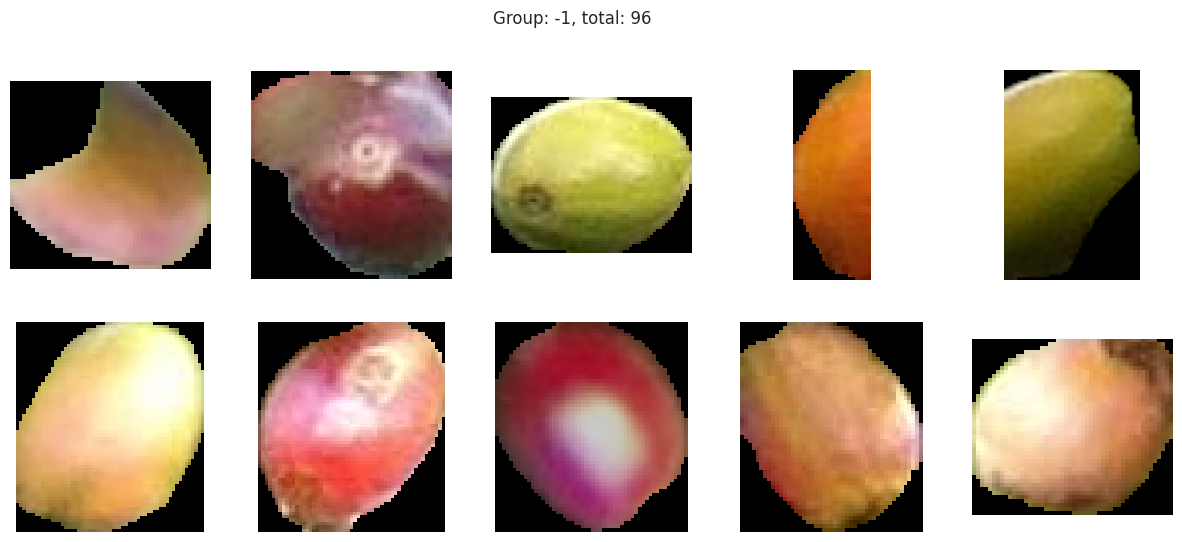

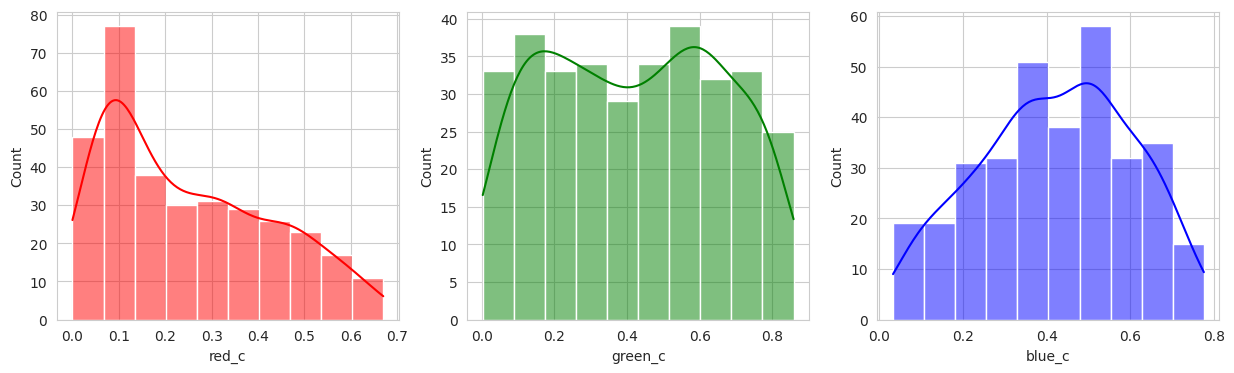

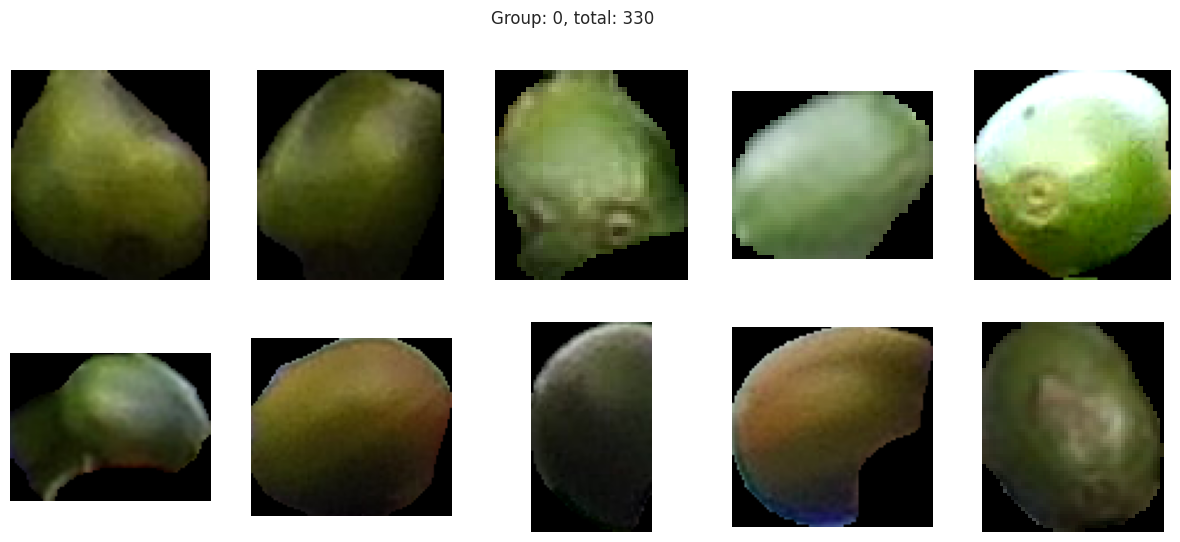

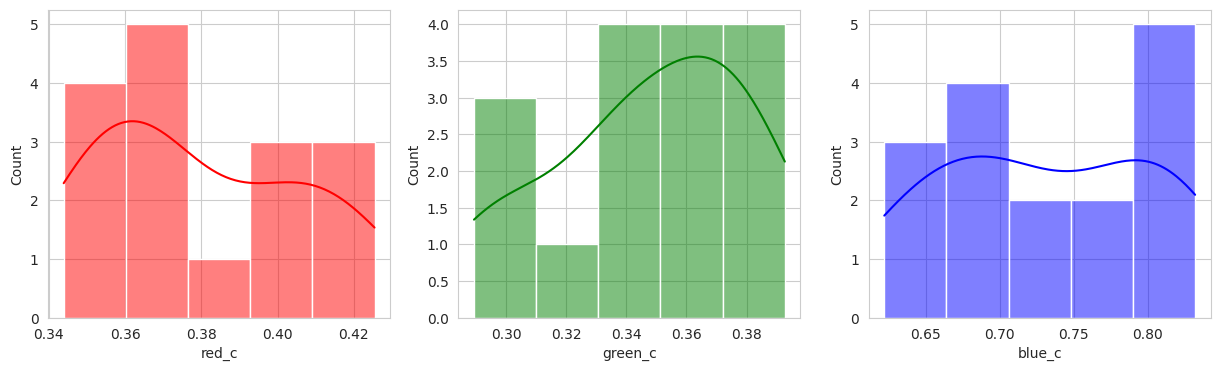

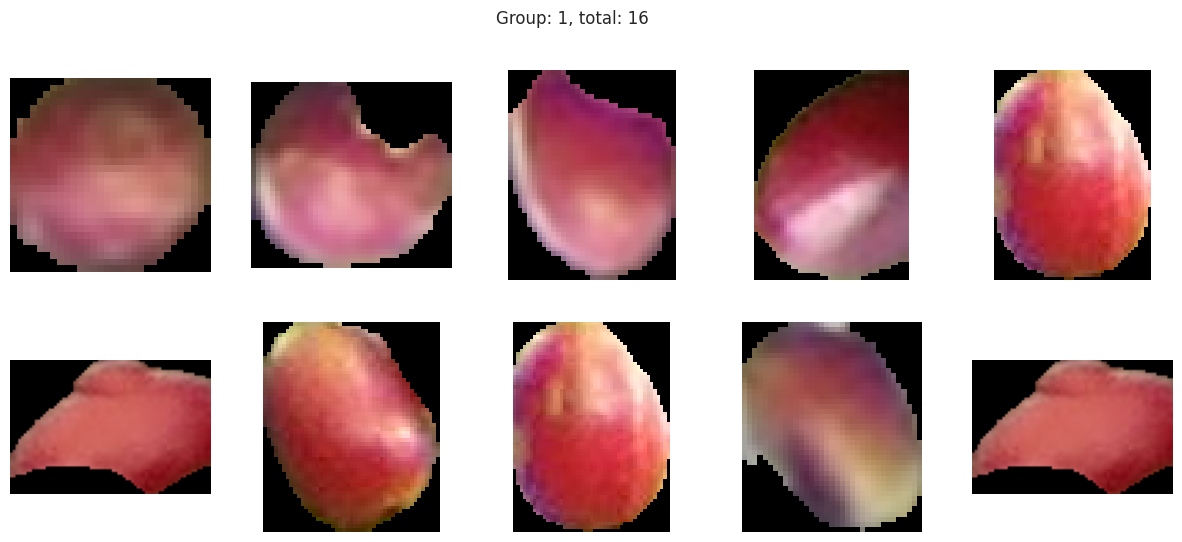

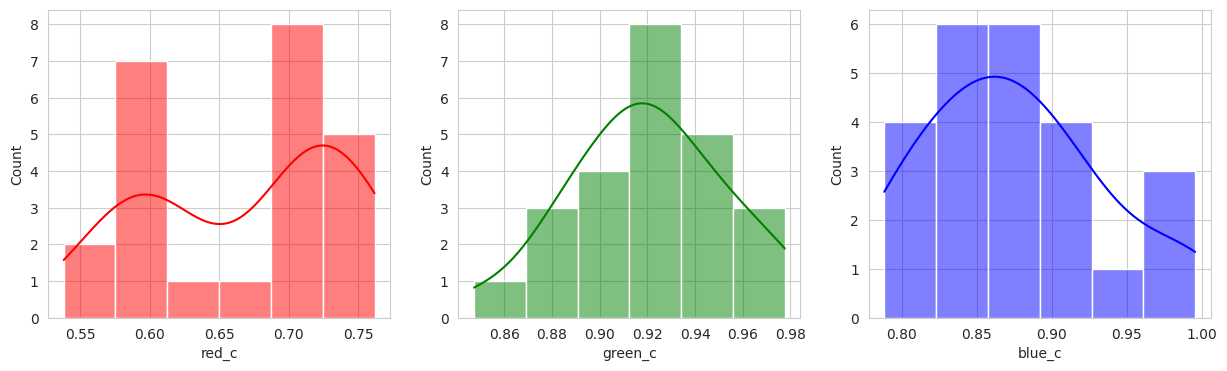

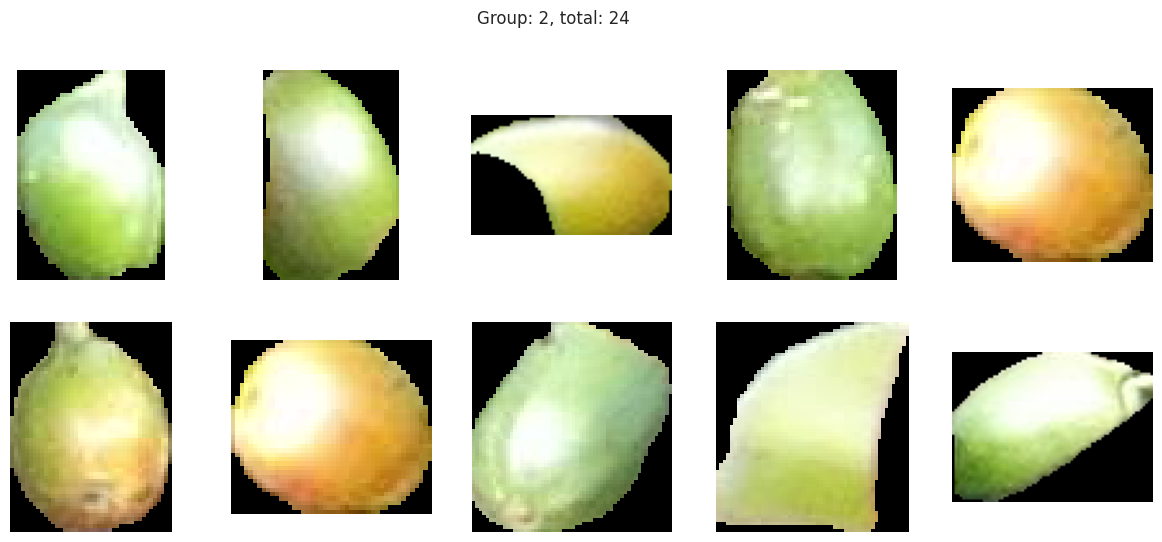

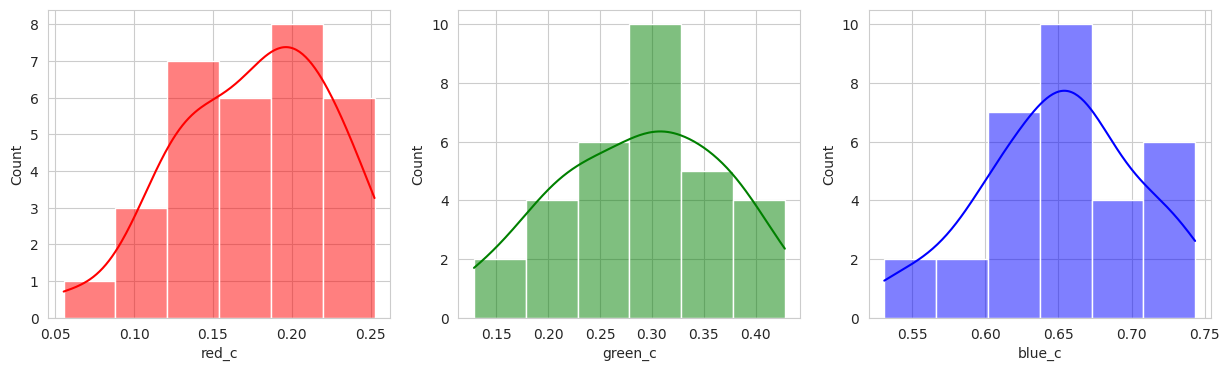

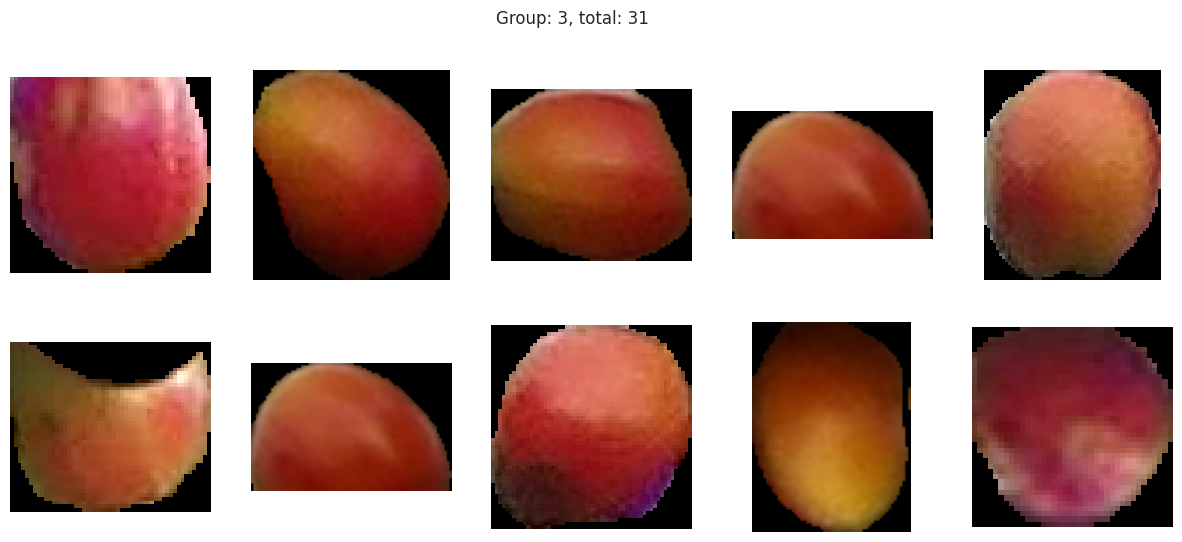

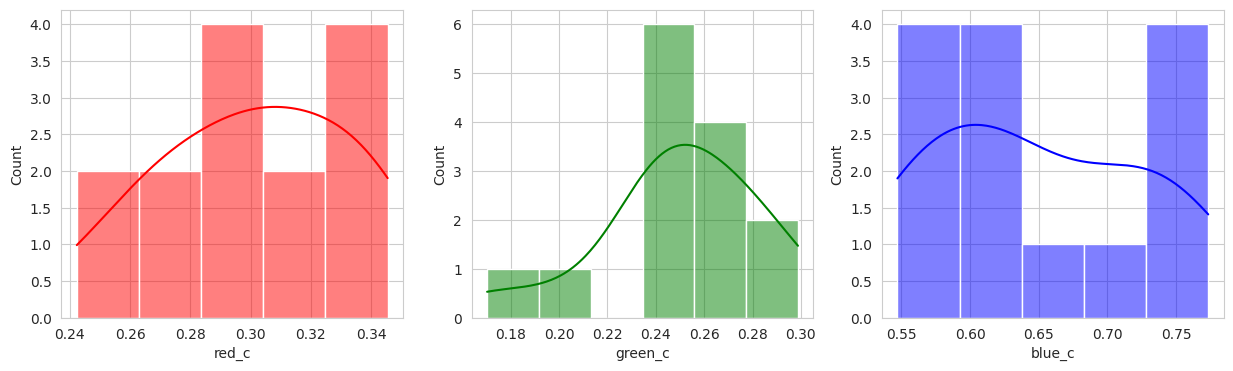

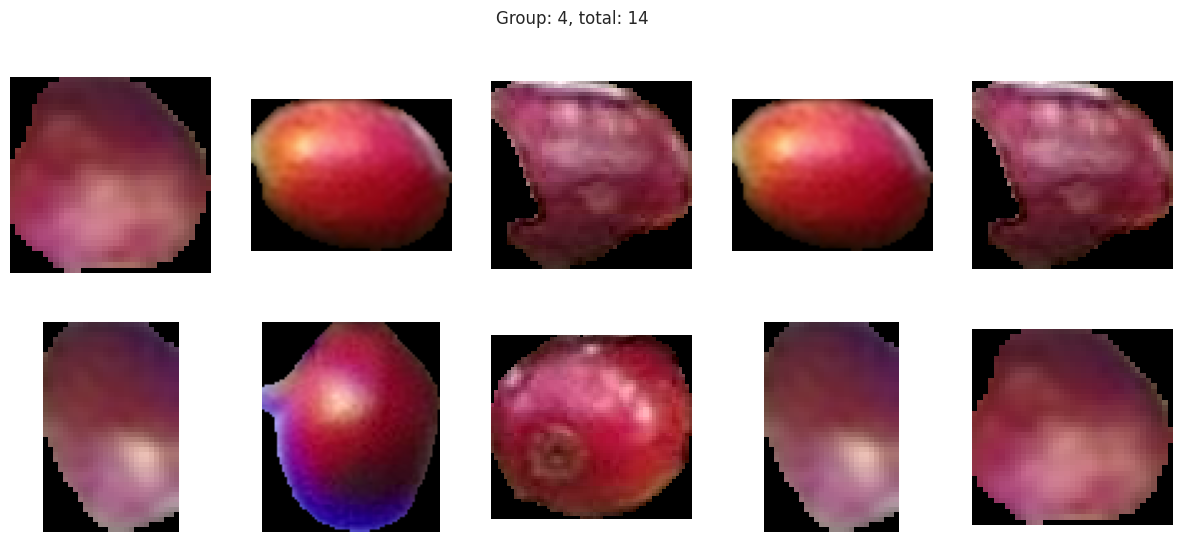

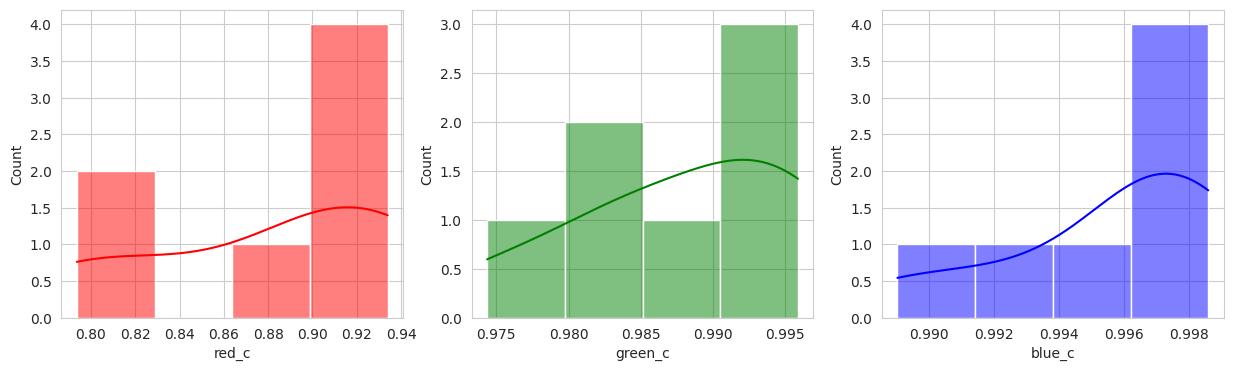

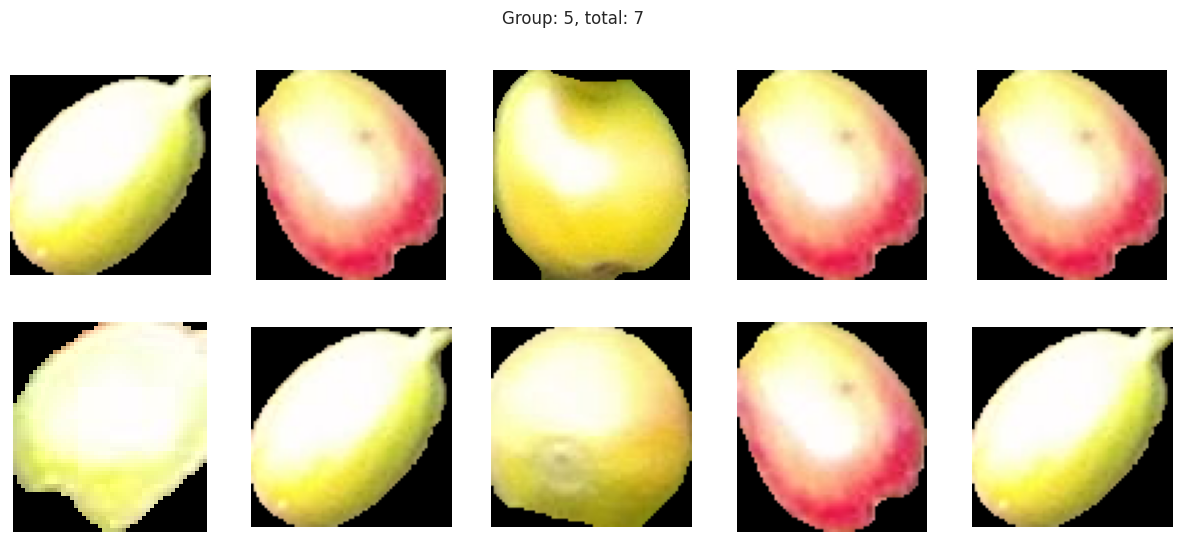

In [138]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=0.08, min_samples=7)

model.fit(x)

fdf['labels'] = model.labels_

sns.pairplot(
    fdf,
    hue='labels',
    palette='pastel',
)

plot_sample_images_from_groups(fdf)

Suprisingly, the DBSCAN model may have classified the berries better than KMeans. The other exception is that the classes are smaller and they appear to have duplicated. There are several classes that could indicate "unripe" berries and several that could indicate "ripe" berries. With a sample set of only a few berries in these classes, I don't like the results. Without the actual classes, we can't observe the performance of the model just yet.

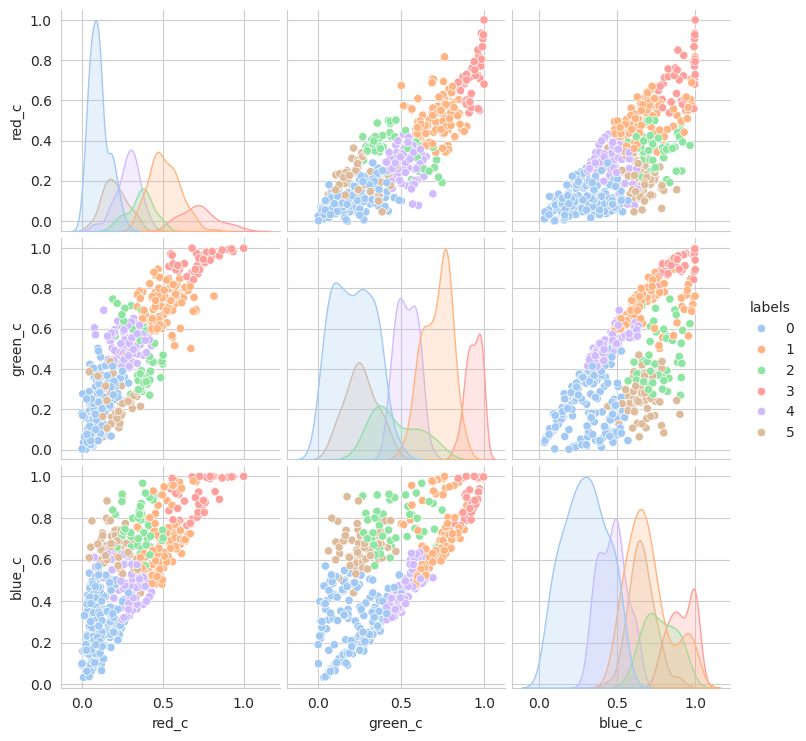

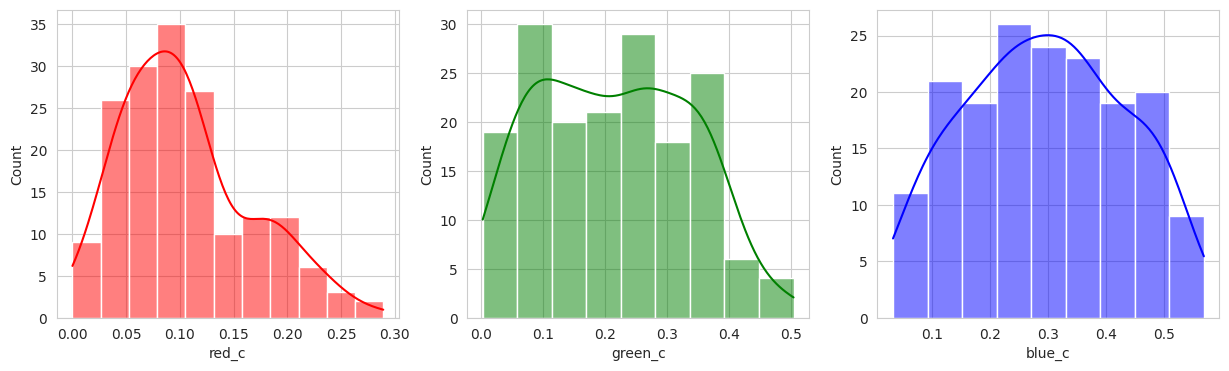

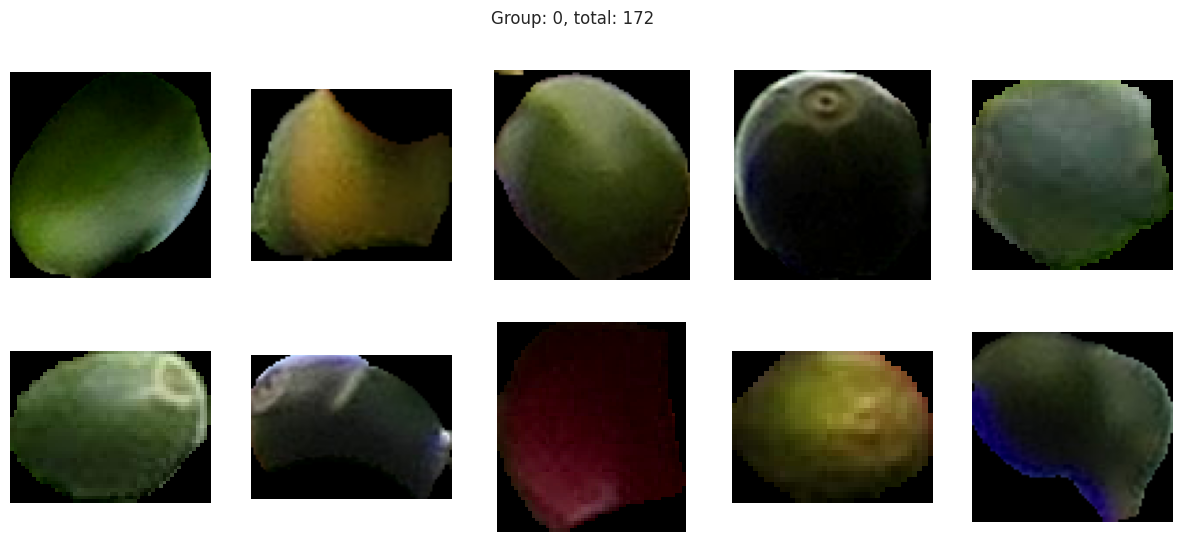

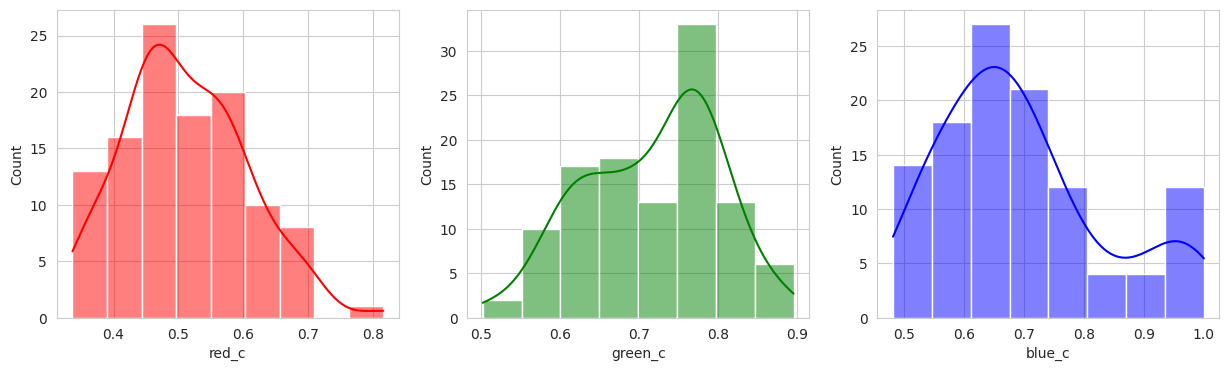

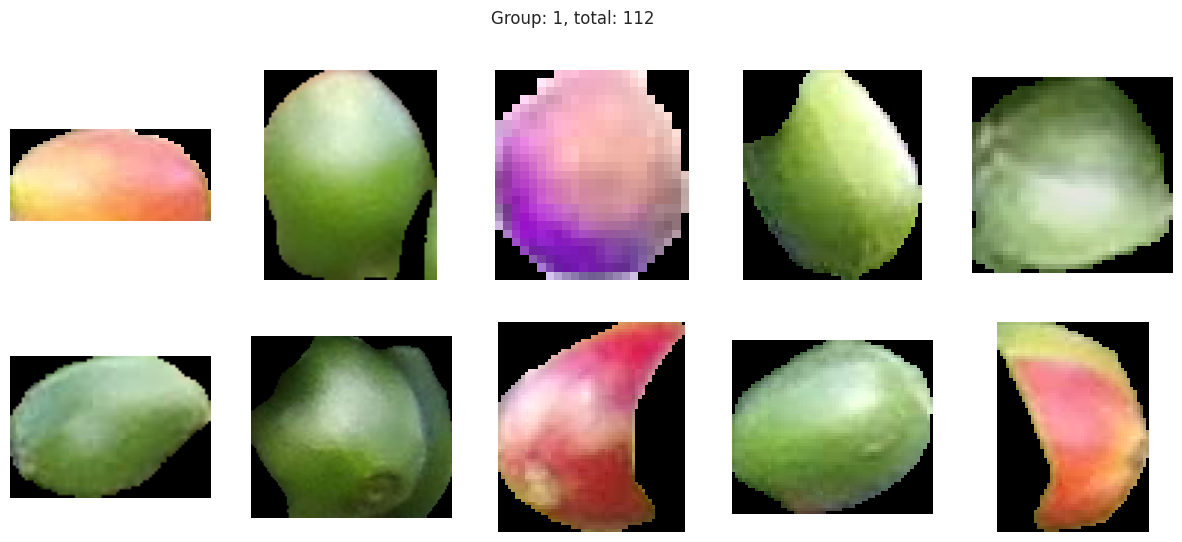

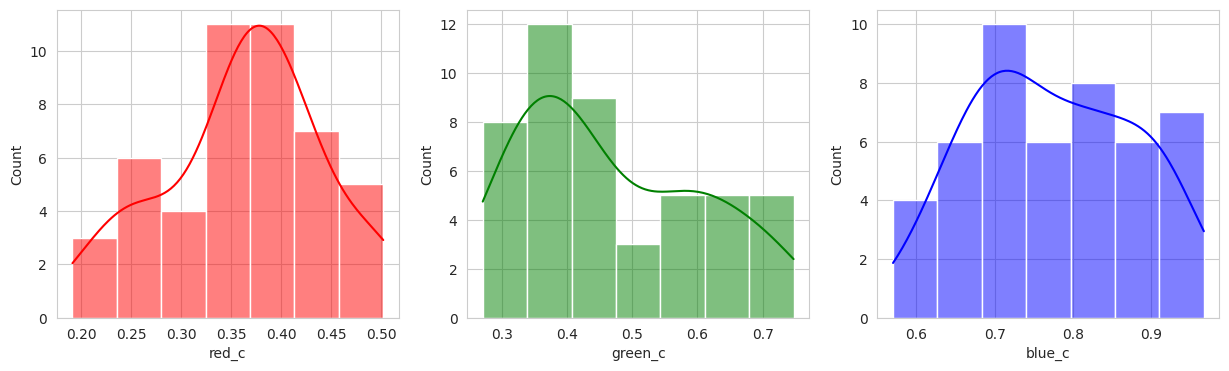

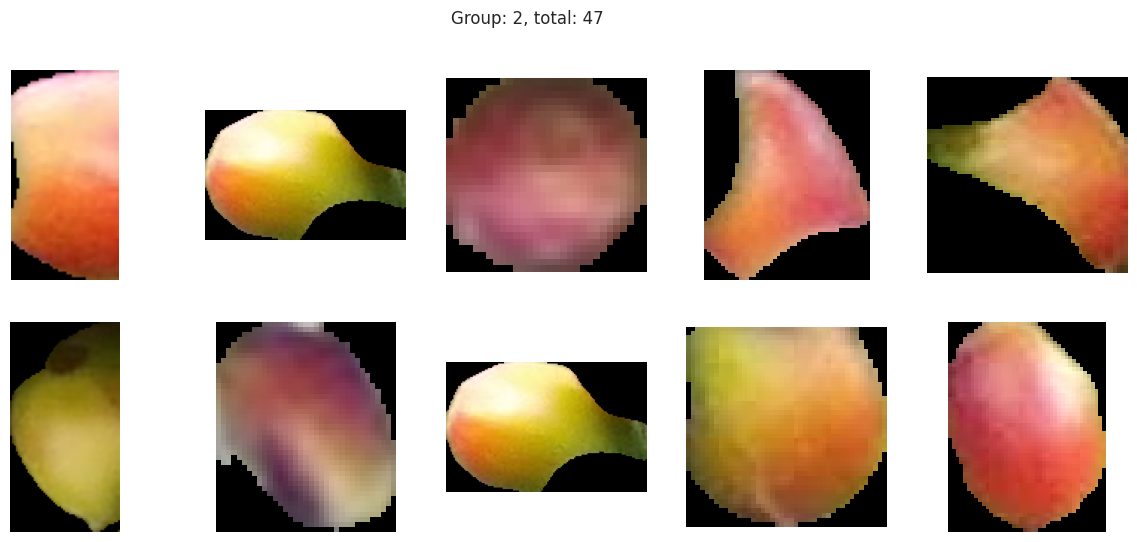

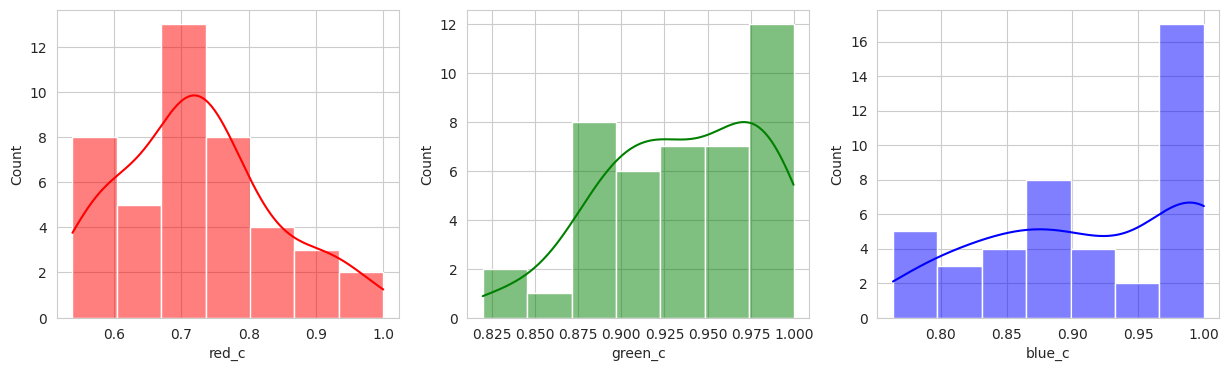

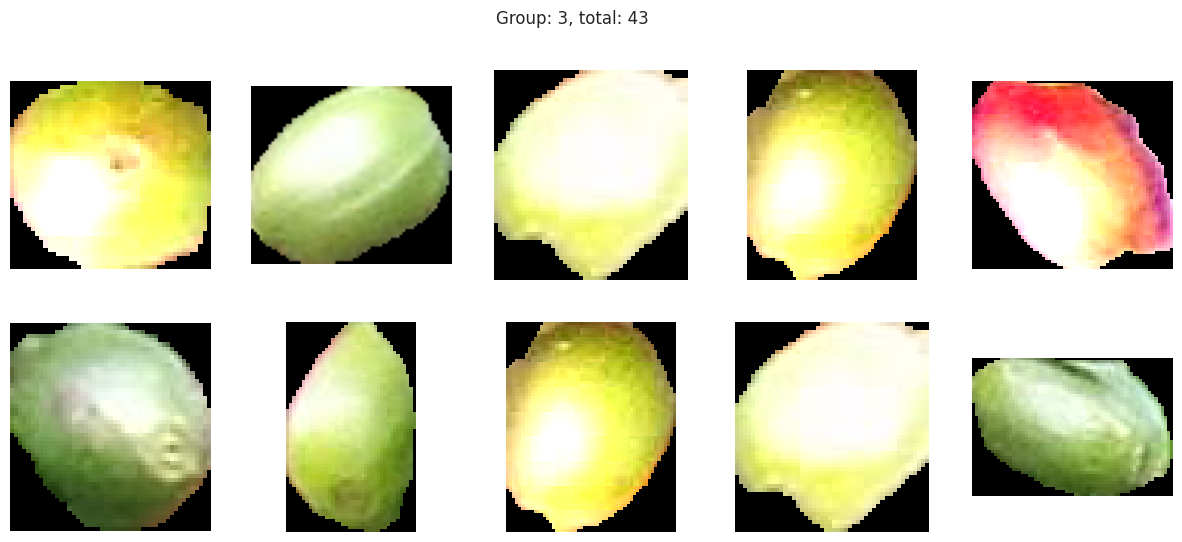

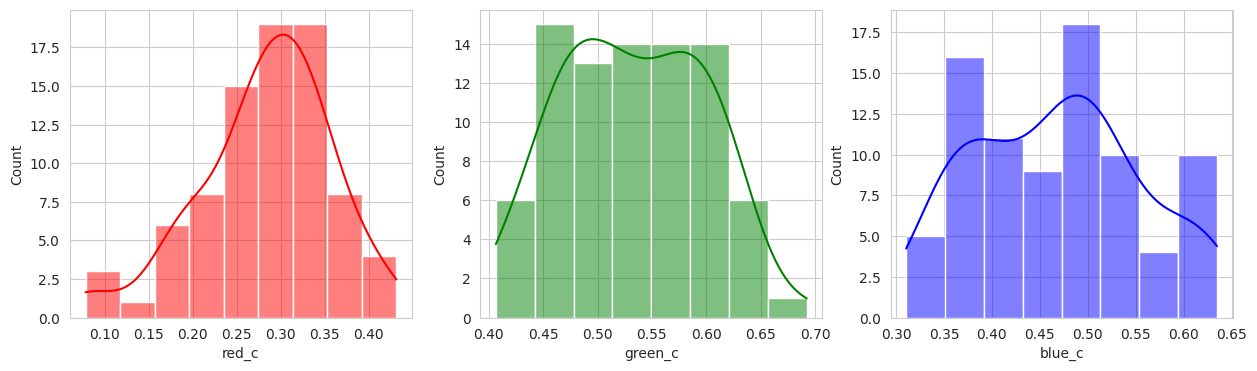

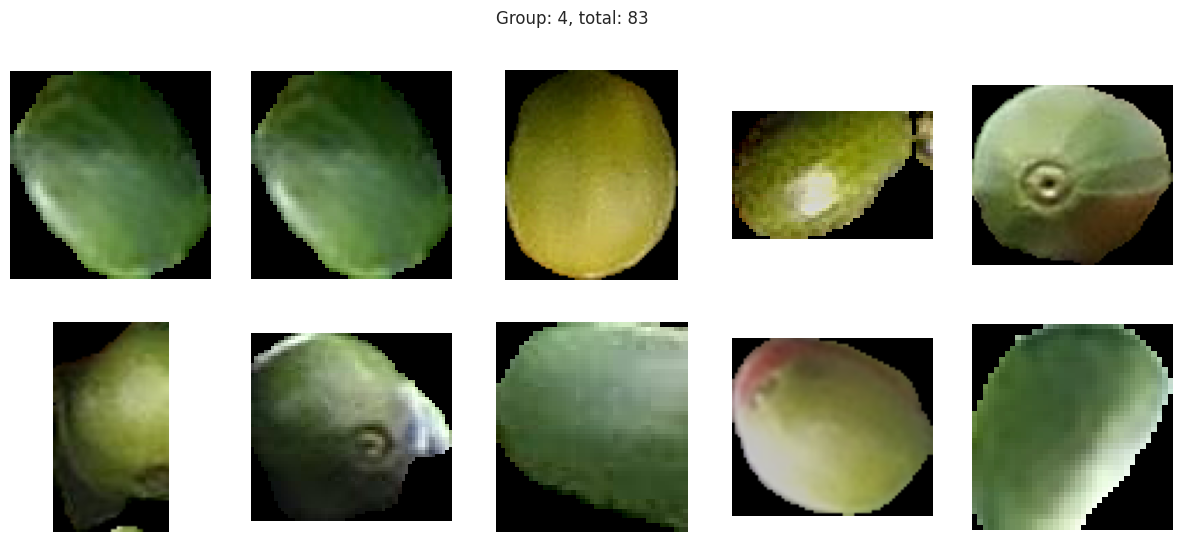

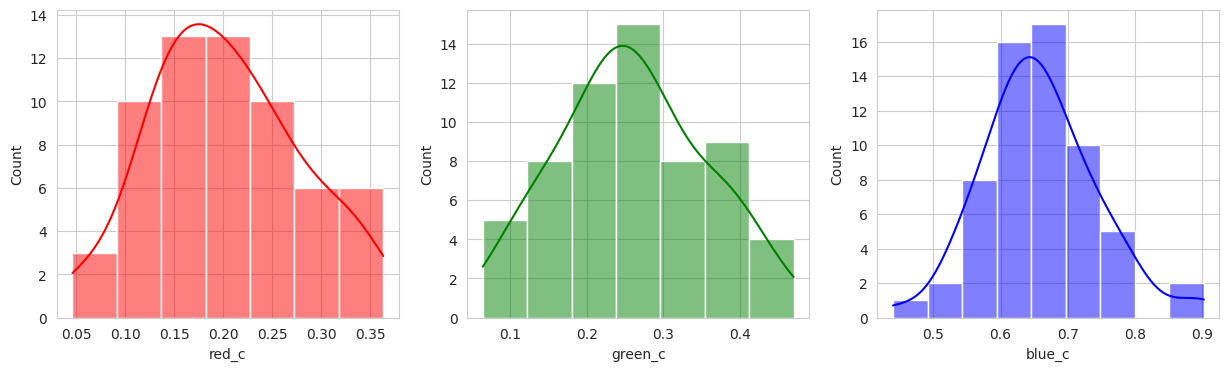

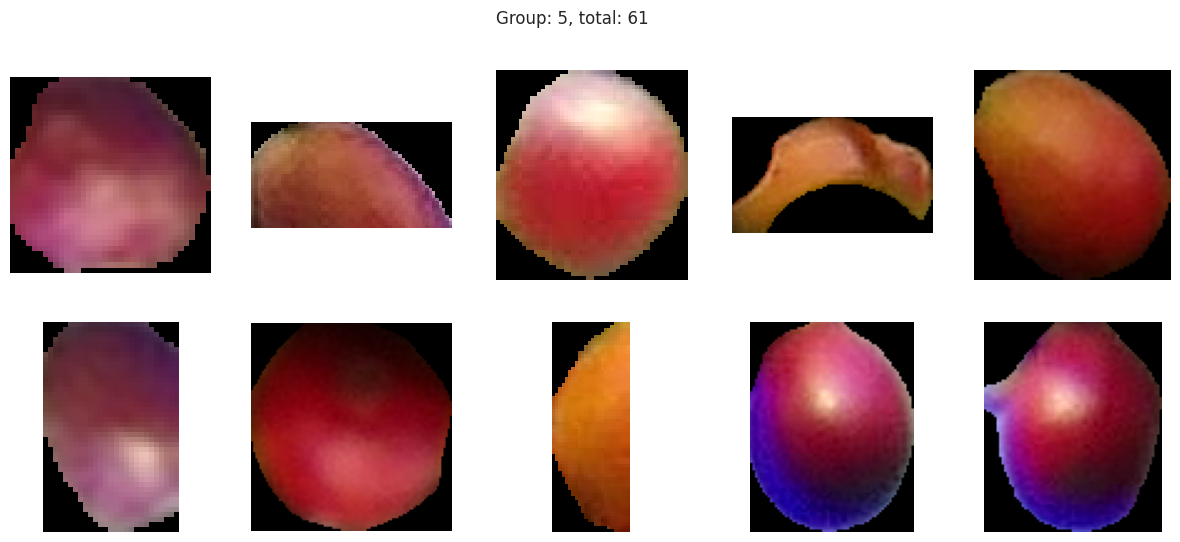

In [140]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=6, linkage='ward')

model.fit(x)

fdf['labels'] = model.labels_

sns.pairplot(
    fdf,
    hue='labels',
    palette='pastel',
)

plot_sample_images_from_groups(fdf)

With the hierachical cluster, the results are very similar to that of the KMeans. In this case, we actually discover a cluster (group 2) that visually appears to be "ripening" where there is a little bit of red and a little bit of green. This is a good sign that the model is working well!

# Conclusion

With the limited dataset, and the lack of actual classes, we can't determine which model is better other than through visual inspection. The DBScan model certainly would require hyperparameter tuning that matches on the actual label to see performance. Given what we see with the KMeans and Hierachical, the initial results are very promising. We can see that the models are able to identify clusters of berries that appear to be of the same lifecycles (unripe, ripening, ripe). With more data and the actual labeled classes, we can train the models to identify the classes and then test the models to see which one performs better at identifying the classes. We can utilizing a confusion matrix to see the rate of false positives and false negatives to determine which model is better. 

In this dataset and use case, more false positives may be more desirable as we want to ensure that we don't miss any berries that are ripe. If there are more ripe berries, this will give the farmer the oppurtunity to schedule a harvest sooner and pick the berries before they turn overripe.

# Follow Ups

- Obtain more datapoints. In addition, the class labels so that statistical analysis can be performed to compare the models to each other. Even though 500 data points may be a lot, there is a lot of variation given different lighting conditions. Further, there were not many "overripe" berries in this dataset given that the images are taken from a farm that is actively harvesting the berries.

- Given that "unripe" berries actually contain a little of green and red in the hue on different parts of the berries, we may consider using multiple points on the berry for reference. This may help the models identify the "unripe" berries better.

- Utilizing the mask, it may be interesting to see if we can identify characteristics of the berry given the contour outline. Some berries may be more round than others, oblong, or even misformed due to disease.